In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Install Normalizer**

In [ ]:
!pip install git+https://github.com/csebuetnlp/normalizer

  Cloning https://github.com/csebuetnlp/normalizer to /tmp/pip-req-build-g8cw004x
  Running command git clone --filter=blob:none --quiet https://github.com/csebuetnlp/normalizer /tmp/pip-req-build-g8cw004x
  Resolved https://github.com/csebuetnlp/normalizer to commit d405944dde5ceeacb7c2fd3245ae2a9dea5f35c9
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.0/185.0 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for normalizer: filename=normalizer-0.0.1-py3-none-any.whl size=6860 sha256=ab1d1522d22fbbdfb48a7969345d2997ad14b7ec708ea91a534c208cdbb7bc40
  Stored in directory: /tmp/pip-ephem-wheel-cache-rvii04xl/wheels/9a/af/fc/4c056274507dc80328a36c6ee1b71d78d6473edb0c1f5edc3e
  Created wheel for emoji: filename=emoji-1.4.2-py3-none-any.whl size=186456 sha256=20cda6870a54786501700db2a65ad1d81ada70bd

# **Import Necessary Libraries**

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from normalizer import normalize

sns.set(style="whitegrid")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# **Loading Dataset**

In [ ]:
DATA_DIR = "/content/drive/MyDrive/dataset"
TRAIN_PATH = os.path.join(DATA_DIR, "train.csv")
TEST_PATH  = os.path.join(DATA_DIR, "test.csv")

In [ ]:
# Load train.csv
train_df = pd.read_csv(TRAIN_PATH)
print(f"Loaded train.csv → {train_df.shape[0]} rows")

# Load test.csv
test_df = pd.read_csv(TEST_PATH)
print(f"Loaded test.csv  → {test_df.shape[0]} rows")

Loaded train.csv → 35200 rows
Loaded test.csv  → 8801 rows


# **drop null and duplicate values**

In [ ]:
train_df.dropna(subset=['text', 'label'], inplace=True)
test_df.dropna(subset=['text'], inplace=True)

In [ ]:
train_df.drop_duplicates(subset=['text'], inplace=True)
test_df .drop_duplicates(subset=['text'], inplace=True)

In [ ]:
print(f"After cleanup → train: {len(train_df)} rows, test: {len(test_df)} rows")

After cleanup → train: 34908 rows, test: 8782 rows


# **define classes for mapping**

In [ ]:
class_to_int = {
    "sexual":  0,
    "not bully": 1,
    "troll":   2,
    "religious": 3,
    "threat":  4
}

# **map labels**

In [ ]:
# Map train labels
train_df['label'] = train_df['label'].map(class_to_int)
print("Train label counts (after mapping):")
print(train_df['label'].value_counts())

# If test.csv has a 'label' column, map it as well (for local evaluation)
if 'label' in test_df.columns:
    test_df['label'] = test_df['label'].map(class_to_int)
    print("\nTest label counts (after mapping):")
    print(test_df['label'].value_counts())
else:
    print("\nTest.csv has no 'label' column (assuming unlabeled test set).")

Train label counts (after mapping):
label
1    12189
2     8323
0     7056
3     5997
4     1343
Name: count, dtype: int64

Test label counts (after mapping):
label
1    3058
2    2091
0    1782
3    1512
4     339
Name: count, dtype: int64


# **Data Distribution**

<ipython-input-12-66a0e79c8fb2>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='label', data=train_df, palette='magma')


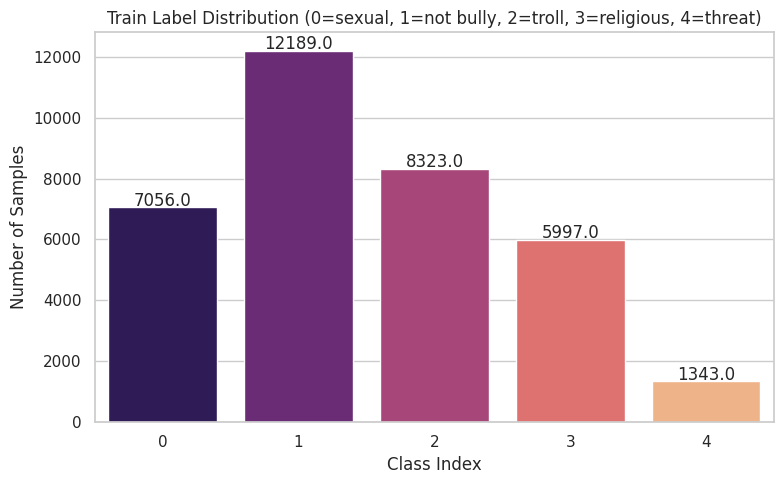

In [ ]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='label', data=train_df, palette='magma')
ax.set_title("Train Label Distribution (0=sexual, 1=not bully, 2=troll, 3=religious, 4=threat)")
ax.set_xlabel("Class Index")
ax.set_ylabel("Number of Samples")
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.0, height + 50, f"{height}", ha='center')
plt.tight_layout()
plt.show()

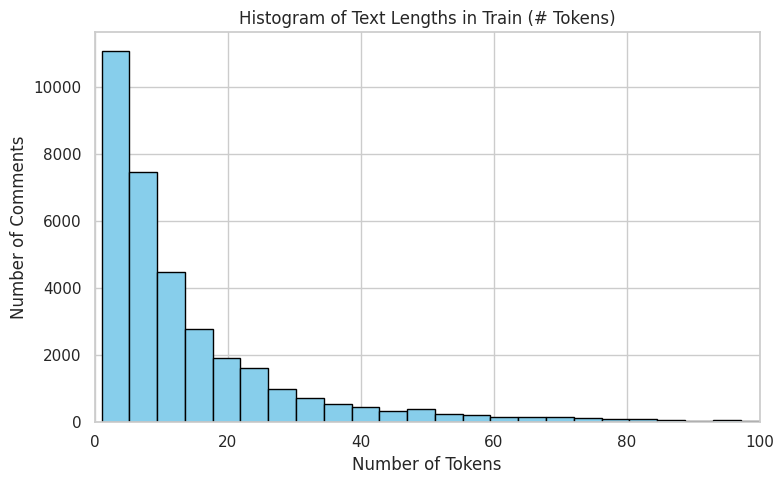

In [ ]:
train_df['text_len_tokens'] = train_df['text'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(8, 5))
plt.hist(train_df['text_len_tokens'], bins=50, color='skyblue', edgecolor='black')
plt.title("Histogram of Text Lengths in Train (# Tokens)")
plt.xlabel("Number of Tokens")
plt.ylabel("Number of Comments")
plt.xlim(0, 100)   # Most Bangla social‐media comments are under 100 tokens
plt.tight_layout()
plt.show()


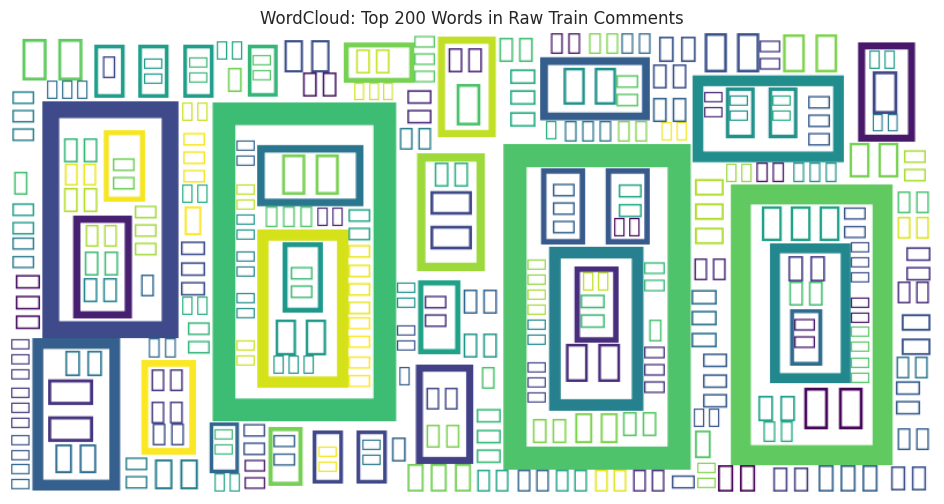

In [ ]:
try:
    from wordcloud import WordCloud, STOPWORDS

    all_text = " ".join(train_df['text'].astype(str).tolist())
    stopwords = set(STOPWORDS)
    wc = WordCloud(
        width=800,
        height=400,
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        collocations=False
    ).generate(all_text)

    plt.figure(figsize=(12, 6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title("WordCloud: Top 200 Words in Raw Train Comments")
    plt.show()

except ImportError:
    print("`wordcloud` not installed; skipping WordCloud. To enable, run: `!pip install wordcloud`")

# **Text Cleaning**

In [ ]:
def clean_text(text: str) -> str:
    text = str(text).strip()
    # Unicode normalization (Bangla-specific)
    text = normalize(text)
    # Lowercase (catches English words if present)
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+', ' ', text)
    # Remove mentions & hashtags
    text = re.sub(r'@\w+', ' ', text)
    text = re.sub(r'#\w+', ' ', text)
    # Remove English & Bangla digits
    text = re.sub(r'[0-9০১২৩৪৫৬৭৮৯]+', ' ', text)
    # Remove punctuation / special characters (keep Bangla letters + space)
    text = re.sub(rf'[^\u0980-\u09FF\s]', ' ', text)
    # Collapse multiple spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [ ]:
# Apply cleaning to train & test
tqdm.pandas(desc="Cleaning Train Texts")
train_df['clean_text'] = train_df['text'].progress_apply(clean_text)

tqdm.pandas(desc="Cleaning Test Texts")
test_df['clean_text']  = test_df['text'].progress_apply(clean_text)

Cleaning Test Texts: 100%|██████████| 8782/8782 [00:06<00:00, 1451.59it/s]


# **Drop empty rows after cleaning**

In [ ]:
num_train_before = len(train_df)
train_df = train_df[train_df['clean_text'].str.strip().astype(bool)]
num_train_after  = len(train_df)
print(f"Dropped {num_train_before - num_train_after} empty rows from train after cleaning.")

num_test_before = len(test_df)
test_df  = test_df[test_df['clean_text'].str.strip().astype(bool)]
num_test_after  = len(test_df)
print(f"Dropped {num_test_before - num_test_after} empty rows from test after cleaning.")

Dropped 0 empty rows from train after cleaning.
Dropped 0 empty rows from test after cleaning.


# **print samples**

In [ ]:
# Peek at some cleaned samples
print("\n=== Sample Cleaned Train Comments ===")
print(train_df[['text','clean_text','label']].sample(3, random_state=7).to_string(index=False))


=== Sample Cleaned Train Comments ===
                                                                            text                                                                        clean_text  label
               তাহলে তুই কি তোর মা বাবার sex দেখেছিলি,  তুই পৃথিবীতে আসলি কি করে                       তাহলে তুই কি তোর মা বাবার দেখেছিলি তুই পৃথিবীতে আসলি কি করে      2
  নিজ হাতে বানাইলাম জিলাপি শুধুমাত্র পরী তোমার জন্য  টেস কইরা জানাবা কিন্তু পরী       নিজ হাতে বানাইলাম জিলাপি শুধুমাত্র পরী তোমার জন্য টেস কইরা জানাবা কিন্তু পরী      1
হয়তো প্রথম আলোর ভুলে গেছে তাদের মতো কোনো ব্যশ্যা নটিকে বাংলারর মানুষ পছন্দ করেনা হয়তো প্রথম আলোর ভুলে গেছে তাদের মতো কোনো ব্যশ্যা নটিকে বাংলারর মানুষ পছন্দ করেনা      0


# **Split data**

In [ ]:
train_split, val_split = train_test_split(
    train_df,
    test_size=0.20,
    stratify=train_df['label'],
    random_state=42
)

In [ ]:
print(f"Train split: {len(train_split)} rows")
print(f"Val split:   {len(val_split)} rows\n")
print("Train split label distribution:")
print(train_split['label'].value_counts(normalize=True))
print("\nVal split label distribution:")
print(val_split['label'].value_counts(normalize=True))

Train split: 27926 rows
Val split:   6982 rows

Train split label distribution:
label
1    0.349173
2    0.238416
0    0.202141
3    0.171811
4    0.038459
Name: proportion, dtype: float64

Val split label distribution:
label
1    0.349184
2    0.238470
0    0.202091
3    0.171727
4    0.038528
Name: proportion, dtype: float64


# **Oversampling to balance the data**

In [ ]:
# === Oversample the training data ===
dfs = []
max_class_size = train_df['label'].value_counts().max()
for label in train_df['label'].unique():
    df_label = train_df[train_df['label'] == label]
    dfs.append(resample(df_label, replace=True, n_samples=max_class_size, random_state=42))
train_df = pd.concat(dfs).sample(frac=1, random_state=42).reset_index(drop=True)

# **custom dataset class**

In [ ]:
class BanglaCommentDataset(Dataset):
    def __init__(self, df: pd.DataFrame, tokenizer, max_length: int = 128, has_label: bool = True):
        """
        df: DataFrame containing 'clean_text' and, if has_label=True, a 'label' column.
        tokenizer: a HuggingFace tokenizer (e.g. BanglaBERT tokenizer)
        max_length: max tokens per sample
        has_label: whether df contains a 'label' column
        """
        self.texts = df['clean_text'].tolist()
        self.has_label = has_label
        self.labels = df['label'].tolist() if has_label else None
        self.tokenizer = tokenizer
        self.max_length = max_length

        print(f"\nInitialized dataset with {len(self.texts)} samples; has_label={self.has_label}")

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        enc = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors="pt"
        )
        item = {
            'input_ids':      enc['input_ids'].squeeze(0),
            'attention_mask': enc['attention_mask'].squeeze(0)
        }
        if self.has_label:
            label = self.labels[idx]
            item['label'] = torch.tensor(label, dtype=torch.long)
        return item

# **loading pre-train model**

In [ ]:
model_name = "csebuetnlp/banglabert"
num_classes = 5

tokenizer = AutoTokenizer.from_pretrained(model_name)
model     = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=num_classes
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/586 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/528k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# **save model to device**

In [ ]:
model.to(device)

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): L

In [ ]:
train_dataset = BanglaCommentDataset(train_split, tokenizer, max_length=128, has_label=True)
val_dataset   = BanglaCommentDataset(val_split,   tokenizer, max_length=128, has_label=True)

# Test (separate; may or may not have labels)
test_has_label = 'label' in test_df.columns
test_dataset = BanglaCommentDataset(test_df, tokenizer, max_length=128, has_label=test_has_label)


Initialized dataset with 27926 samples; has_label=True

Initialized dataset with 6982 samples; has_label=True

Initialized dataset with 8782 samples; has_label=True


# **Dataloaders**

In [ ]:
BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  drop_last=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False)

# **Train model**

In [ ]:
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_split['label']),
    y=train_split['label']
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)
print(f"Class weights (for CrossEntropyLoss): {class_weights.cpu().numpy()}")


Class weights (for CrossEntropyLoss): [0.9894065 0.5727823 0.8388705 1.1640683 5.200372 ]


In [ ]:
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [ ]:
LEARNING_RATE = 2e-5
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)

In [ ]:
# === Training Loop with Early Stopping ===
NUM_EPOCHS = 10
PATIENCE = 3
best_val_loss = float('inf')
epochs_no_improve = 0
SAVE_PATH = "/content/drive/MyDrive/dataset/best_model.pt"

for epoch in range(NUM_EPOCHS):
    epoch_start = torch.cuda.Event(enable_timing=True)
    epoch_start.record()
    model.train()
    total_loss = 0
    for step, batch in enumerate(tqdm(train_loader, desc=f"Epoch {epoch+1}")):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_train_loss = total_loss / len(train_loader)

    # === Validation ===
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            val_loss += criterion(outputs.logits, labels).item()
    avg_val_loss = val_loss / len(val_loader)

    # Track time
    epoch_end = torch.cuda.Event(enable_timing=True)
    epoch_end.record()
    torch.cuda.synchronize()
    elapsed_time = epoch_start.elapsed_time(epoch_end) / 1000  # seconds
    print(f"Epoch {epoch+1} completed in {elapsed_time//60:.0f}m {elapsed_time%60:.0f}s")
    print("-" * 60)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), SAVE_PATH)
        print("Saved improved model.")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print("Early stopping.")
            break



Epoch 1:   0%|          | 2/1745 [00:01<17:38,  1.65it/s]

model.safetensors:   0%|          | 0.00/443M [00:00<?, ?B/s]

Epoch 1: 100%|██████████| 1745/1745 [10:00<00:00,  2.91it/s]


Epoch 1 completed in 10m 54s
------------------------------------------------------------
Saved improved model.


Epoch 2: 100%|██████████| 1745/1745 [10:07<00:00,  2.87it/s]


Epoch 2 completed in 11m 0s
------------------------------------------------------------
Saved improved model.


Epoch 3: 100%|██████████| 1745/1745 [10:07<00:00,  2.87it/s]


Epoch 3 completed in 11m 0s
------------------------------------------------------------


Epoch 4: 100%|██████████| 1745/1745 [10:06<00:00,  2.88it/s]


Epoch 4 completed in 10m 60s
------------------------------------------------------------


Epoch 5: 100%|██████████| 1745/1745 [10:07<00:00,  2.87it/s]


Epoch 5 completed in 11m 0s
------------------------------------------------------------
Early stopping.


# **Saving Model**

In [ ]:
torch.save(model.state_dict(), 'sentiment.bin')

In [ ]:
from transformers import AutoModelForSeq2SeqLM
# Save the model
model.save_pretrained("/content/drive/MyDrive/dataset/sentiment_model.pt")
# Save the tokenizer
tokenizer.save_pretrained("/content/drive/MyDrive/dataset/sentiment_tokenizer.json")

('/content/drive/MyDrive/dataset/sentiment_tokenizer.json/tokenizer_config.json',
 '/content/drive/MyDrive/dataset/sentiment_tokenizer.json/special_tokens_map.json',
 '/content/drive/MyDrive/dataset/sentiment_tokenizer.json/vocab.txt',
 '/content/drive/MyDrive/dataset/sentiment_tokenizer.json/added_tokens.json',
 '/content/drive/MyDrive/dataset/sentiment_tokenizer.json/tokenizer.json')

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Load model and tokenizer
model = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/dataset/sentiment_model.pt")
tokenizer = AutoTokenizer.from_pretrained("/content/drive/MyDrive/dataset/sentiment_tokenizer.json")

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

loaded_model = AutoModelForSequenceClassification.from_pretrained(Model_Save)
loaded_tokenizer = AutoTokenizer.from_pretrained(Model_Save)
loaded_model.to(device)
loaded_model.eval()

# evaluate on the validation data
eval_loader = val_loader


# Iterate and collect prediction & labels
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(eval_loader, desc="Evaluating"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        outputs = loaded_model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()

        all_preds.extend(preds)

        # If the DataLoader includes labels, grab them:
        if 'label' in batch:
            all_labels.extend(batch['label'].cpu().numpy())

# 14.4. Compute metrics if labels are present
if len(all_labels) > 0:
    from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    report = classification_report(all_labels, all_preds, digits=4)
    cm = confusion_matrix(all_labels, all_preds)

    print(f"\n Accuracy: {acc:.4f}")
    print(f" Weighted F1: {f1:.4f}\n")
    print(" Classification Report:\n", report)
else:
    # If no labels in eval_loader (e.g. unlabeled test), just save predictions
    out_df = pd.DataFrame({
        "id": test_df.index if 'id' not in test_df.columns else test_df['id'],
        "predicted_label": all_preds
    })
    out_df.to_csv("predictions.csv", index=False)
    print("Predictions saved to `predictions.csv`.")

NameError: name 'Model_Save' is not defined

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)

class_names = ['sexual', 'not bully', 'troll', 'religious', 'threat']

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names,
    vmin=100,
    vmax=1000
)

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# **Convert model to onnx format**

In [ ]:
!pip install onnx onnxruntime

In [ ]:
import os
import torch

SAVE_DIR = "/content/drive/MyDrive/dataset/bangla_comment_classifier"
os.makedirs(SAVE_DIR, exist_ok=True)

# Define the ONNX filepath
ONNX_PATH = os.path.join(SAVE_DIR, "model.onnx")

# Move model to CPU, set eval mode
loaded_model.to("cpu")
loaded_model.eval()

# Create dummy inputs (batch_size=1, seq_len=128)
batch_size = 1
seq_len = 128
dummy_input_ids = torch.randint(
    low=0,
    high=loaded_tokenizer.vocab_size,
    size=(batch_size, seq_len),
    dtype=torch.long
)
dummy_attention_mask = torch.ones(
    size=(batch_size, seq_len),
    dtype=torch.long
)

# Export to ONNX with dynamic axes
torch.onnx.export(
    loaded_model,
    (dummy_input_ids, dummy_attention_mask),
    ONNX_PATH,
    export_params=True,
    opset_version=11,
    do_constant_folding=True,
    input_names=['input_ids', 'attention_mask'],
    output_names=['logits'],
    dynamic_axes={
        'input_ids': {0: 'batch_size', 1: 'seq_len'},
        'attention_mask': {0: 'batch_size', 1: 'seq_len'},
        'logits': {0: 'batch_size'}
    }
)

print(f"ONNX model successfully saved to: {ONNX_PATH}")